La prédiction de l'attrition, ou "churn", est une tâche assez généralisée en machine learning. Il s'agit de prédire la probabilité qu'un client quitte l'entreprise.

C'est une tâche de classification supervisée, basée sur une variable-cible binaire.

Dans ce notebook, nous allons mettre en place cette prédiction de churn. Nous utiliserons un dataset issu de Kaggle. Nous l'explorerons dans la partie EDA (exploratory data analysis), puis le nettoierons afin de les préparer à la modélisation. Enfin, nous comparerons les performances de différents modèles de machine learning, en testant divers hyper-paramètres pour chacun d'entre eux, afin de déterminer un "best_model".

In [1]:
import kagglehub

In [3]:
# Import des librairies

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import cross_val_predict, StratifiedKFold, ParameterGrid, KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,recall_score
from xgboost import XGBClassifier
import xgboost as xgb
from scipy import stats
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import os
from sklearn.metrics import precision_recall_curve
import gc
from sklearn.metrics import confusion_matrix, make_scorer

In [4]:
#Initialisation de DagsHub pour suivi sur MLFlow
%pip install -q dagshub mlflow
import mlflow
import mlflow.sklearn
import dagshub



In [5]:
path = kagglehub.dataset_download('mathchi/churn-for-bank-customers')
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/churn-for-bank-customers


In [6]:
df = pd.read_csv("/kaggle/input/churn-for-bank-customers/churn.csv", index_col=0)
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#EDA

##Distribution

In [8]:
# aucun doublon
print(df.duplicated().sum())
# aucune valeur manquante
print(df.isnull().sum())

0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [7]:
df_0 = df[df['Exited'] == 0] #Distrib des clients restés
df_1 = df[df['Exited'] == 1] #Distrib des clients partis

cols_exclues = ['Exited','CustomerId','Surname']
categorical_feats = ["Geography","Gender","IsActiveMember","NumOfProducts","HasCrCard"]
continuous_feats = [col for col in df.columns if col not in categorical_feats and col not in cols_exclues]


In [10]:
display(df.info())
print(df['Exited'].value_counts(normalize=True))


<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


None

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


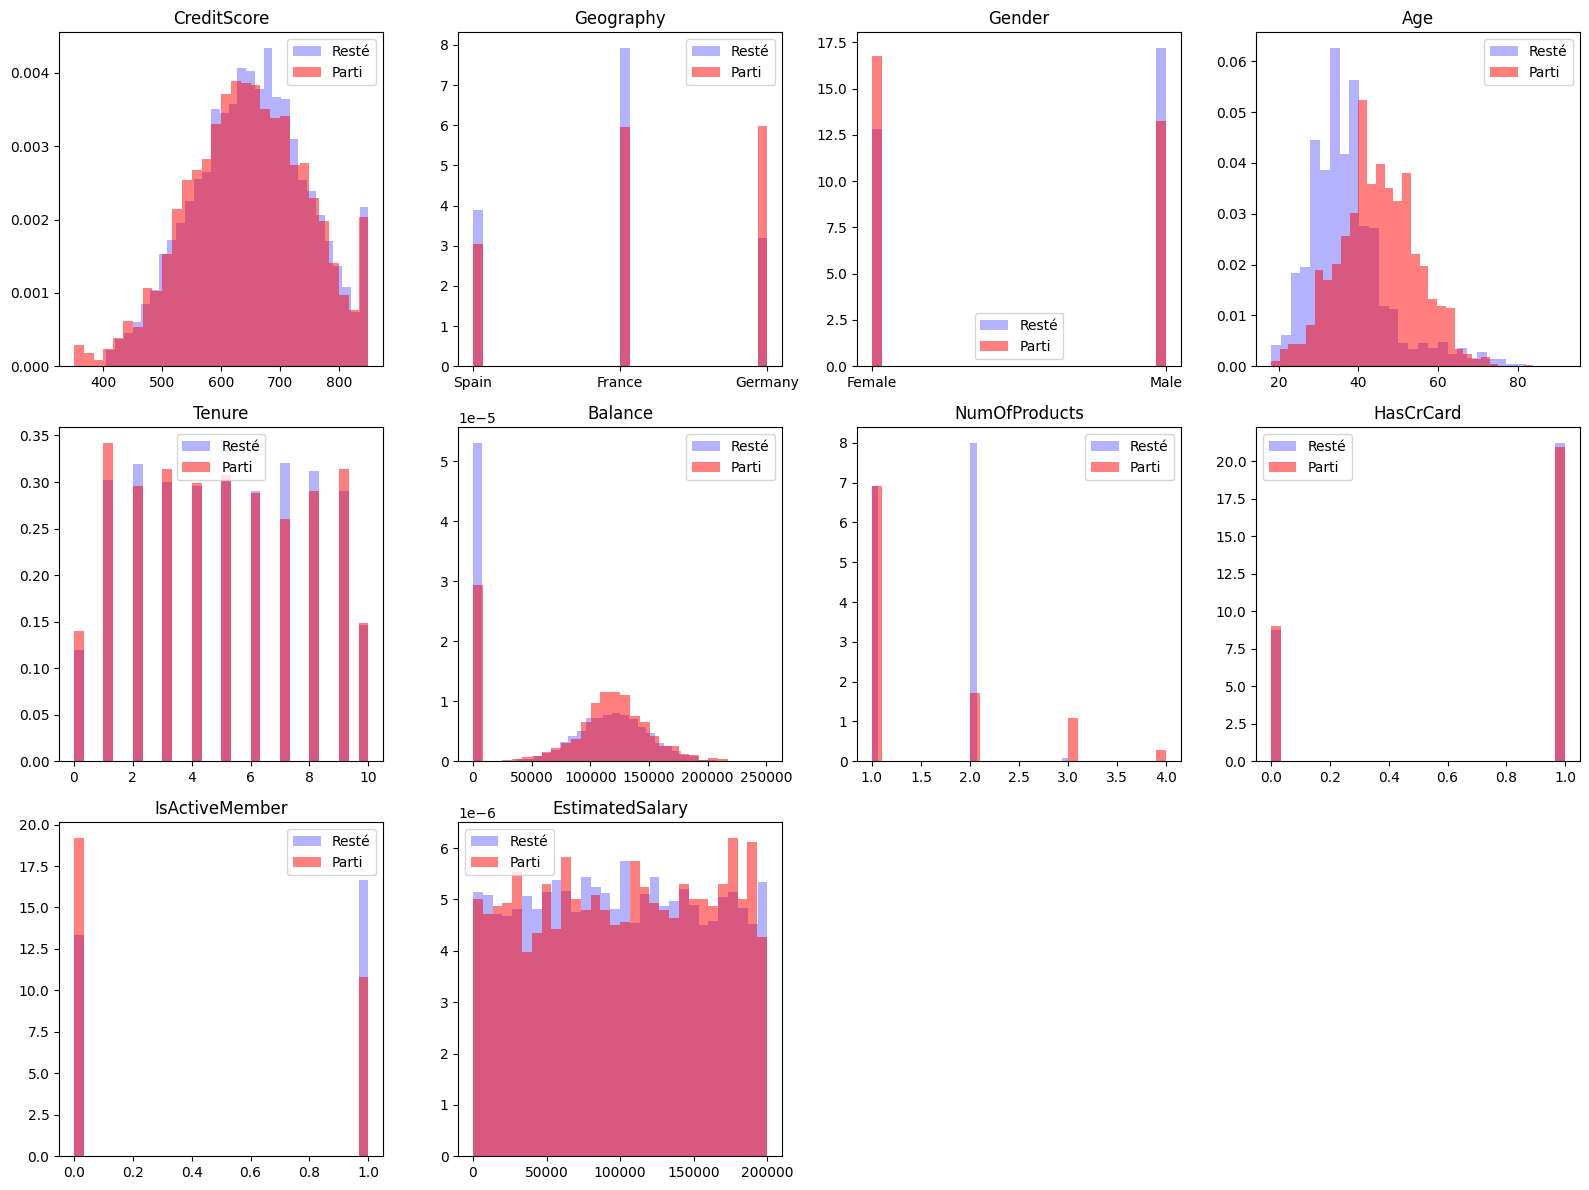

In [13]:
features = [col for col in df.columns if col not in cols_exclues] #Pour éviter d'afficher la distribution de la colonne Exited

n_cols = 4
n_rows = (len(features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
axes = axes.ravel()
for i, col in enumerate(features):
    axes[i].hist(df_0[col], bins=30, alpha=0.3, label='Resté', color='blue', density=True)
    axes[i].hist(df_1[col], bins=30, alpha=0.5, label='Parti', color='red', density=True)
    axes[i].set_title(col)
    axes[i].legend()


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##Variables catégorielles

In [14]:
for col in categorical_feats:
    print(f"\n--- {col} ---")
    table = pd.crosstab(df[col], df['Exited'], normalize='columns') * 100
    table = table.round(1)
    print(table)


--- Geography ---
Exited        0     1
Geography            
France     52.8  39.8
Germany    21.3  40.0
Spain      25.9  20.3

--- Gender ---
Exited     0     1
Gender            
Female  42.7  55.9
Male    57.3  44.1

--- IsActiveMember ---
Exited             0     1
IsActiveMember            
0               44.5  63.9
1               55.5  36.1

--- NumOfProducts ---
Exited            0     1
NumOfProducts            
1              46.2  69.2
2              53.3  17.1
3               0.6  10.8
4               0.0   2.9

--- HasCrCard ---
Exited        0     1
HasCrCard            
0          29.3  30.1
1          70.7  69.9


##Variables continues

In [15]:
for col in continuous_feats:
  a = df_0[col].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])
  b = df_1[col].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])
  c = pd.concat([a, b], axis=1)
  c.columns = ['Exited = 0', 'Exited = 1']
  c = c.round(1)
  print(f"\n--- {col} ---")
  print(c)





--- CreditScore ---
       Exited = 0  Exited = 1
count      7963.0      2037.0
mean        651.9       645.4
std          95.7       100.3
min         405.0       350.0
5%          492.0       479.0
25%         585.0       578.0
50%         653.0       646.0
75%         718.0       716.0
90%         778.0       776.4
95%         812.0       812.2
99%         850.0       850.0
max         850.0       850.0

--- Age ---
       Exited = 0  Exited = 1
count      7963.0      2037.0
mean         37.4        44.8
std          10.1         9.8
min          18.0        18.0
5%           24.0        29.0
25%          31.0        38.0
50%          36.0        45.0
75%          41.0        51.0
90%          49.0        58.0
95%          59.0        61.0
99%          73.0        68.0
max          92.0        84.0

--- Tenure ---
       Exited = 0  Exited = 1
count      7963.0      2037.0
mean          5.0         4.9
std           2.9         2.9
min           0.0         0.0
5%            1.0   

##Matrice de corrélation

<Axes: >

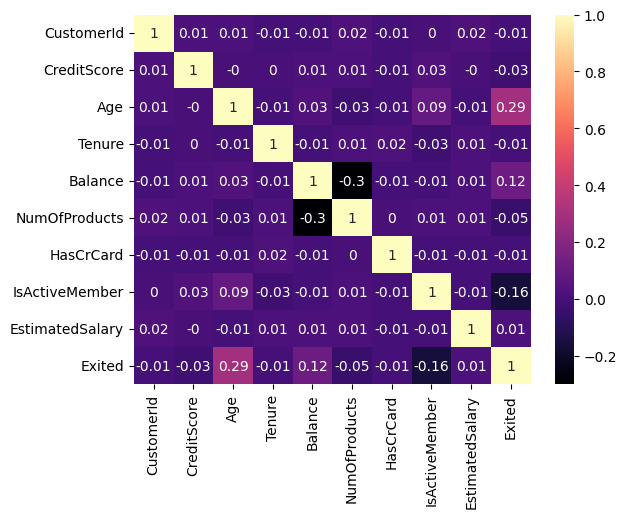

In [16]:
mat = df.corr(method='pearson', numeric_only=True).round(2)
sns.heatmap(mat, annot=True, cmap = 'magma')

##Insights

**CreditScore** : Distrib similaires

**Geography** : Une forte proportion des clients partis sont allemands.

**Gender**: On note une surreprésentation des clients partis chez les femmes.

**Age**: La population des clients partis est plus âgée que celle des clients restés, mais au-delà de 70 ans, les clients ont tendance à rester.

**Tenure** : Distrib similaires

**Balance** : Distrib similaires

**NumOfProducts** : La plupart des clients n'ont acheté qu'un seul produit issu de la banque, mais une proportion non-négligeable des clients partis avaient acheté 3 ou 4 produits. La grande majorité des clients restés n'ont acheté que 2 produits alors que la majorité des clients partis n'ont acheté qu'un seul produit.

**HasCrCard** : Distrib similaires

**IsActiveMember** : Les clients actifs restent plus que les clients inactifs.

**EstimatedSalary** : Un pourcentage important de clients disposant d'un salaire de 150000 à 190000 ont quitté la banque.




#Data cleaning et preprocessing

##Détection des valeurs aberrantes

In [8]:
z_scores = np.abs(stats.zscore(df[continuous_feats]))

outliers = df[continuous_feats][(z_scores >= 3).any(axis=1)]
print(outliers)
outliers_count = (z_scores >= 3).sum(axis=0)
print(f"Nombre d'outliers par variable : \n{outliers_count}")

# On garde les lignes où toutes les scores standard sont < 3 pour les colonnes sélectionnées (fonctionne car mes variables suivent une distrib normale)
#df_filtered = df[(z_scores < 3).all(axis=1)]

# Pas besoin de cette étape, car les outliers de l'âge ne sont pas aberrants (voir dernier percentile : les plus vieux clients sont considérés comme aberrants, mais leur âge semble cohérent).
# Je ne supprime pas de valeur.


           CreditScore  Age  Tenure    Balance  EstimatedSalary
RowNumber                                                      
86                 652   75      10       0.00        114675.75
159                646   73       6   97259.25        104719.66
231                673   72       1       0.00        111981.19
253                681   79       0       0.00        170968.99
311                652   80       4       0.00        188603.07
...                ...  ...     ...        ...              ...
9647               850   71      10   69608.14         97893.40
9672               649   78       4   68345.86        142566.75
9737               659   78       2  151675.65         49978.67
9895               521   77       6       0.00         49054.10
9937               609   77       1       0.00         18708.76

[141 rows x 5 columns]
Nombre d'outliers par variable : 
CreditScore          8
Age                133
Tenure               0
Balance              0
EstimatedSalary   

##Préparation des données pour la modélisation

In [9]:
#On divise les variables continues en catégories ordinales
df["NewCreditsScore"] = pd.qcut(df['CreditScore'], 6, labels = [1, 2, 3, 4, 5, 6])
df["NewAgeScore"] = pd.qcut(df['Age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
df["NewBalanceScore"] = pd.qcut(df['Balance'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
df["NewEstSalaryScore"] = pd.qcut(df['EstimatedSalary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [10]:
#One-hot encoding simple pour les deux variables catégorielles
# Variables to apply one hot encoding
list_drop = ["Gender", "Geography"]
df = pd.get_dummies(df, columns =list_drop, drop_first = True)

In [11]:
df = df.drop(["CustomerId","Surname"], axis = 1)

In [12]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NewCreditsScore,NewAgeScore,NewBalanceScore,NewEstSalaryScore,Gender_Male,Geography_Germany,Geography_Spain
RowNumber,,,,,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,3,6,1,6,False,False,False
2,608,41,1,83807.86,1,0,1,112542.58,0,2,6,3,6,False,False,True
3,502,42,8,159660.80,3,1,0,113931.57,1,1,6,5,6,False,False,False
4,699,39,1,0.00,2,0,0,93826.63,0,5,5,1,5,False,False,False
5,850,43,2,125510.82,1,1,1,79084.10,0,6,6,4,4,False,False,True


##Scaling

In [13]:
new_cols = ["Gender_Male","Geography_Germany","Geography_Spain"]
#Je ne scale que les variables continues ayant beaucoup de valeurs différentes.
#Cela permet de conserver la simplicité des variables binaires et des variables à faible cardinalité.
cols_discrete_few = [col for col in df.columns if df[col].dtypes != 'O' and len(df[col].value_counts()) <= 10]
col_scale = [col for col in df.columns if col not in new_cols and col not in "Exited" and col not in cols_discrete_few]

#RobustScaler est robuste aux outliers que nous avons conservé dans la variable Age.
scaler = RobustScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled["Exited"] = df_scaled["Exited"].astype(int)

In [14]:
df_scaled.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NewCreditsScore,NewAgeScore,NewBalanceScore,NewEstSalaryScore,Gender_Male,Geography_Germany,Geography_Spain
0,-0.246269,0.416667,-0.75,-0.761480,0.0,0.0,0.0,0.011739,1,0.000000,0.50,-1.0,0.1,-1.0,0.0,0.0
1,-0.328358,0.333333,-1.00,-0.104906,0.0,-1.0,0.0,0.125512,0,-0.333333,0.50,0.0,0.1,-1.0,0.0,1.0
2,-1.119403,0.416667,0.75,0.489346,2.0,0.0,-1.0,0.139630,1,-0.666667,0.50,1.0,0.1,-1.0,0.0,0.0
3,0.350746,0.166667,-1.00,-0.761480,1.0,-1.0,-1.0,-0.064717,0,0.666667,0.25,-1.0,-0.1,-1.0,0.0,0.0
4,1.477612,0.500000,-0.75,0.221806,0.0,0.0,0.0,-0.214561,0,1.000000,0.50,0.5,-0.3,-1.0,0.0,1.0


#Modélisation

In [15]:
#Création des jeux d'entraînement et de test
X = df_scaled.drop("Exited", axis=1)
y = df_scaled["Exited"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [16]:
#Création de la cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [17]:
#Création de grille de paramètres pour chaque modèle à tester
model_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42),
        "params": {
            'model__C': [0.01, 0.1, 1, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight='balanced', random_state=42),
        "params": {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10, 20],
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            'model__n_estimators': [100, 200],
            'model__max_depth': [3, 6],
            'model__learning_rate': [0.01, 0.1],
            'model__scale_pos_weight': [4, 5]  # Approximatif pour 20% de churn --> (%classe majoritaire / %classe minoritaire) --> 0.8/0.2 = 4
        }
    }
}

In [18]:
# Résultats
liste_tresholds = [0.45,0.5,0.55,0.6] #On teste plusieurs seuils de classification
results = []
for tresh in liste_tresholds:
  for name, config in model_grids.items():
    with mlflow.start_run(nested=True, run_name=name):
      print(f"--- Entraînement {name} ---")



      pipe = Pipeline(steps=[
          ('smote', SMOTE(random_state=42)),
          ('model', config["model"])
      ])

      grid = GridSearchCV(pipe, param_grid=config["params"], cv=cv, scoring='roc_auc', n_jobs=-1, verbose=0)
      grid.fit(X_train, y_train)

      best_model = grid.best_estimator_
      y_pred = (best_model.predict_proba(X_test)[:,1] >= tresh).astype(bool)
      y_prob = best_model.predict_proba(X_test)[:, 1]

      auc = roc_auc_score(y_test, y_prob)
      f1 = f1_score(y_test, y_pred)
      print("Répartition réelle (y_test) :", np.bincount(y_test))
      print("Répartition prédite (y_pred) :", np.bincount(y_pred))
      report = classification_report(y_test, y_pred, output_dict=True)

      results.append({
          "Tresh":tresh,
          "Modèle": name,
          "Best params": grid.best_params_,
          "ROC AUC": auc,
          "F1-score": f1,
          "Recall": report["1"]["recall"],
          "Précision": report["1"]["precision"]
      })

      mlflow.log_params(grid.best_params_)
      mlflow.log_metric("Seuil", tresh)
      mlflow.log_metric("ROC AUC", auc)
      mlflow.log_metric("F1-score", f1)
      mlflow.log_metric("Recall", report["1"]["recall"])
    mlflow.end_run()

# Affichage résultats
results_df = pd.DataFrame(results).sort_values("ROC AUC", ascending=False)
pd.set_option('display.max_colwidth', None)
print(results_df[["Modèle", "Tresh", "ROC AUC", "F1-score", "Recall", "Précision", "Best params"]])

--- Entraînement Logistic Regression ---
Répartition réelle (y_test) : [1593  407]
Répartition prédite (y_pred) : [1116  884]
--- Entraînement Random Forest ---
Répartition réelle (y_test) : [1593  407]
Répartition prédite (y_pred) : [1520  480]
--- Entraînement XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:17:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Répartition réelle (y_test) : [1593  407]
Répartition prédite (y_pred) : [1113  887]
--- Entraînement Logistic Regression ---
Répartition réelle (y_test) : [1593  407]
Répartition prédite (y_pred) : [1232  768]
--- Entraînement Random Forest ---
Répartition réelle (y_test) : [1593  407]
Répartition prédite (y_pred) : [1599  401]
--- Entraînement XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:19:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Répartition réelle (y_test) : [1593  407]
Répartition prédite (y_pred) : [1206  794]
--- Entraînement Logistic Regression ---
Répartition réelle (y_test) : [1593  407]
Répartition prédite (y_pred) : [1370  630]
--- Entraînement Random Forest ---
Répartition réelle (y_test) : [1593  407]
Répartition prédite (y_pred) : [1662  338]
--- Entraînement XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:21:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Répartition réelle (y_test) : [1593  407]
Répartition prédite (y_pred) : [1305  695]
--- Entraînement Logistic Regression ---
Répartition réelle (y_test) : [1593  407]
Répartition prédite (y_pred) : [1467  533]
--- Entraînement Random Forest ---
Répartition réelle (y_test) : [1593  407]
Répartition prédite (y_pred) : [1704  296]
--- Entraînement XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:23:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Répartition réelle (y_test) : [1593  407]
Répartition prédite (y_pred) : [1383  617]
                 Modèle  Tresh   ROC AUC  F1-score    Recall  Précision  \
2               XGBoost   0.45  0.868025  0.537867  0.855037   0.392334   
11              XGBoost   0.60  0.868025  0.609375  0.766585   0.505673   
8               XGBoost   0.55  0.868025  0.602541  0.815725   0.477698   
5               XGBoost   0.50  0.868025  0.574521  0.847666   0.434509   
10        Random Forest   0.60  0.860258  0.586060  0.506143   0.695946   
7         Random Forest   0.55  0.860258  0.593289  0.542998   0.653846   
1         Random Forest   0.45  0.860258  0.615558  0.670762   0.568750   
4         Random Forest   0.50  0.860258  0.606436  0.601966   0.610973   
3   Logistic Regression   0.50  0.793900  0.512340  0.739558   0.391927   
0   Logistic Regression   0.45  0.793900  0.492641  0.781327   0.359729   
6   Logistic Regression   0.55  0.793900  0.514947  0.656020   0.423810   
9   Logistic Re

In [19]:
results_df.head()

,Tresh,Modèle,Best params,ROC AUC,F1-score,Recall,Précision
2,0.45,XGBoost,"{'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__scale_pos_weight': 4}",0.868025,0.537867,0.855037,0.392334
11,0.60,XGBoost,"{'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__scale_pos_weight': 4}",0.868025,0.609375,0.766585,0.505673
8,0.55,XGBoost,"{'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__scale_pos_weight': 4}",0.868025,0.602541,0.815725,0.477698
5,0.50,XGBoost,"{'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__scale_pos_weight': 4}",0.868025,0.574521,0.847666,0.434509
10,0.60,Random Forest,"{'model__max_depth': 10, 'model__n_estimators': 200}",0.860258,0.586060,0.506143,0.695946


##Tracé de la courbe Precision-Recall pour choisir un seuil de classification

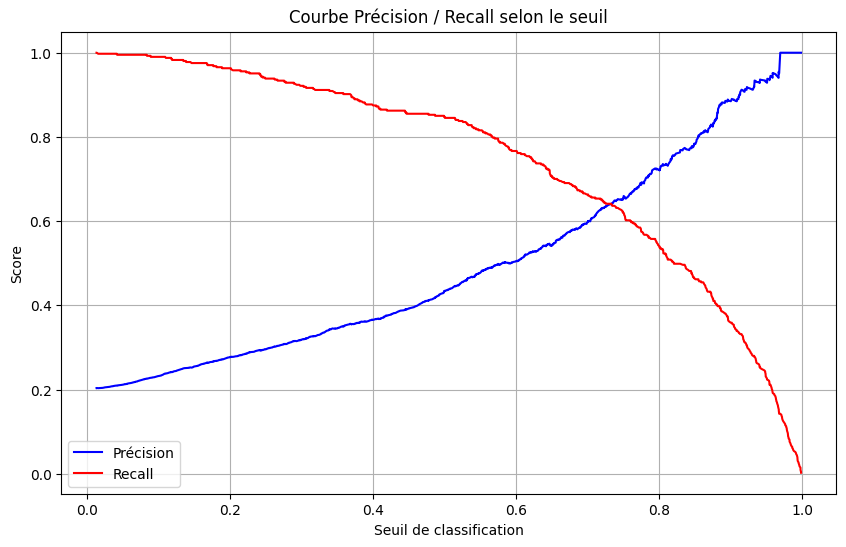

In [52]:
y_scores = best_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label="Précision", color='blue')
plt.plot(thresholds, recalls[:-1], label="Recall", color='red')
plt.xlabel("Seuil de classification")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.title("Courbe Précision / Recall selon le seuil")
plt.show()

##Insights de la modélisation
- La ROC AUC mesure la capacité du modèle à discriminer entre les clients partis (1) et restés (0).
- Le Recall mesure la capacité du modèle à repérer les vrais churners.
- La Précision mesure la proportion de vrais churners classés comme churners par le modèle.
- XGBoost est un bon choix, dans la mesure où une entreprise aura intérêt à privilégier un modèle repérant le maximum de churners véritables, quitte à générer de faux positifs.
- Nous obtenons une AUC d'environ 0.87, ce qui est satisfaisant. Une entreprise pourra ensuite sélectionner le seuil de classification qui lui convient : 0.6 laissera passer plus de churners, mais 0.45 repérera beaucoup de faux positifs. 0.55 semble un bon compromis.


In [36]:
best_model = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, scale_pos_weight=4, eval_metric='logloss', random_state=42)
best_model.fit(X_train, y_train)

y_probs = best_model.predict_proba(X_test)[:, 1]
threshold = 0.55
y_pred_custom_threshold = (y_probs > threshold).astype(int)

print("Répartition réelle (y_test) :", np.bincount(y_test))
print("Répartition prédite (y_pred_custom_threshold) :", np.bincount(y_pred_custom_threshold))
# Affichage de la matrice de confusion avec un heatmap
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_custom_threshold).ravel()
print("Matrice de confusion :")
print(f"Vrais Négatifs : {tn}, Faux Positifs : {fp}, Faux Négatifs : {fn}, Vrais Positifs : {tp}")

Répartition réelle (y_test) : [1593  407]
Répartition prédite (y_pred_custom_threshold) : [1474  526]
Matrice de confusion :
Vrais Négatifs : 1355, Faux Positifs : 238, Faux Négatifs : 119, Vrais Positifs : 288
